In [4]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import pandas as pd
import healpy as hp
import pymaster as nmt
import pyccl as ccl
import pyccl.nl_pt as pt
import pymaster as nmt
from tools import *

# Read catalog and split the redshift bins

In [5]:
# data_path1 =  '/home/gabriela/Documents/Pesquisa/kxgal_new/data/data_input/raw_data/monroy/'
data_path1 = "/home/ketchup/DES_ACT_test/"

cat = load_fits2pd(data_path1+'data.fits')
cat_z1  = cat[(cat['DNF_ZMEAN_SOF']> 0.2) &(cat['DNF_ZMEAN_SOF']< 0.40) ]
print(len(cat_z1) ,' total number of galaxies' )
cat_z1.index = range(len(cat_z1))

cat_z2  = cat[(cat['DNF_ZMEAN_SOF']> 0.4) &(cat['DNF_ZMEAN_SOF']< 0.55) ]
print(len(cat_z2) ,' total number of galaxies' )
cat_z2.index = range(len(cat_z2))


cat_z3  = cat[(cat['DNF_ZMEAN_SOF']> 0.55) &(cat['DNF_ZMEAN_SOF']< 0.7) ]
print(len(cat_z3) ,' total number of galaxies' )
cat_z3.index = range(len(cat_z3))


cat_z4  = cat[(cat['DNF_ZMEAN_SOF']> 0.7) &(cat['DNF_ZMEAN_SOF']< 0.85) ]
print(len(cat_z4) ,' total number of galaxies' )
cat_z4.index = range(len(cat_z4))


cat_z5  = cat[(cat['DNF_ZMEAN_SOF']> 0.85) &(cat['DNF_ZMEAN_SOF']< 0.95) ]
print(len(cat_z5) ,' total number of galaxies' )
cat_z5.index = range(len(cat_z5))


cat_z6  = cat[(cat['DNF_ZMEAN_SOF']> 0.95) &(cat['DNF_ZMEAN_SOF']< 1.05) ]
print(len(cat_z6) ,' total number of galaxies' )
cat_z6.index = range(len(cat_z6))
catals = [cat_z1,cat_z2,cat_z3,cat_z4,cat_z5,cat_z6]

des_bins = 6

2236462  total number of galaxies
1599487  total number of galaxies
1627408  total number of galaxies


2175171  total number of galaxies
1583679  total number of galaxies
1494243  total number of galaxies


# Set fiducial parameters, firstly follow the fiducial parameters listed in https://arxiv.org/abs/2105.13546

In [6]:
cosmo = ccl.Cosmology(Omega_c= 0.252, Omega_b=0.048, h=0.69 , A_s=2.19e-9, n_s=0.97,
                      matter_power_spectrum='halofit')
# linear galaxy bias
bias_zs= [1.5,1.8,1.8,1.9,1.57,1.64]
# nonlinear galaxy bias, given by the combinination of b and sigma_8
bias_1_zs_sigma8 = [1.43,1.43,1.43,1.69,1.69,1.69]
bias_2_zs_sigma8 = [0.16,0.16,0.16,0.36,0.36,0.36]
sigma_8 = 0.758
bias_1_zs = np.array(bias_1_zs_sigma8)/sigma_8
bias_2_zs = np.array(bias_2_zs_sigma8)/sigma_8
bias_s_zs = -4/7*(bias_1_zs-1)

# lens magnification
sz_zs = [0.642, 0.63, 0.766, 0.794, 0.756, 0.896]

In [7]:
# Get the CMB lensing PS based on the fiducal cosmology

In [8]:
nside = 256
ell = np.arange(0, 3*nside-1)
cmbl = ccl.CMBLensingTracer(cosmo, 1090.)
clkk_th  =  ccl.angular_cl(cosmo, cmbl,cmbl, ell)

# Compute and save theory Cls using linear galaxy bias model,  based on Gabriela's script 

In [9]:
if 0:
    for i in range(des_bins):
        zz, nz = get_nz(catals[i])
        
        ccl_z1 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, bias_zs[i]*np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[i]*np.ones(len(zz)) ))
        #CL_k_bin
        cl_kg_th = ccl.angular_cl(cosmo, ccl_z1,cmbl, ell)
        np.savetxt(data_path1 + 'input_linear/clkg_input_z%s.dat' %(i+1), np.transpose((ell, cl_kg_th)))

        for j in range(i, des_bins):
        
            zz, nz = get_nz(catals[j])
            ccl_z2 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, bias_zs[j]*np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[j]*np.ones(len(zz)) ))

            #CL_g1_g2
            cl_gg_th = ccl.angular_cl(cosmo, ccl_z1,ccl_z2, ell)
            np.savetxt(data_path1 + 'input_linear/clgg_input_z%sf2z%s.dat' %(i+1,j+1), np.transpose((ell, cl_gg_th)))

# Compute and save theory Cls using non linear galaxy bias model,  edited by Hongbo

In [10]:
# consider nonlinear galaxy bias here, use PT tools
if 0:
    ptc = pt.PTCalculator(with_NC=True, with_IA=True,
                          log10k_min=-4, log10k_max=2, nk_per_decade=20)

    for i in range(des_bins):
        zz, nz = get_nz(catals[i])
        
        ccl_z1 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[i]*np.ones(len(zz)) ))
    

        ptt_g_z1 = pt.PTNumberCountsTracer(b1=(zz, bias_1_zs[i]*np.ones(len(zz))), b2=(zz, bias_2_zs[i]*np.ones(len(zz))), bs=(zz, bias_s_zs[i]*np.ones(len(zz))))
        ptt_m = pt.PTMatterTracer()

        pk_gm = pt.get_pt_pk2d(cosmo, ptt_g_z1, tracer2=ptt_m, ptc=ptc)

        #CL_k_bin
        cl_kg_th = ccl.angular_cl(cosmo, ccl_z1, cmbl, ell, p_of_k_a=pk_gm)
        np.savetxt(data_path1 + 'input_nonlinear/clkg_input_nl_z%s.dat' %(i+1), np.transpose((ell, cl_kg_th)))
    
        for j in range(i, des_bins):        
            zz, nz = get_nz(catals[j])
        
            ccl_z2 = ccl.NumberCountsTracer(cosmo,False,(zz,nz), bias= (zz, np.ones(len(zz)) ),  mag_bias=  (zz, sz_zs[j]*np.ones(len(zz)) ))
        
            ptt_g_z2 = pt.PTNumberCountsTracer(b1=(zz, bias_1_zs[j]*np.ones(len(zz))), b2=(zz, bias_2_zs[j]*np.ones(len(zz))), bs=(zz, bias_s_zs[j]*np.ones(len(zz))))

            pk_gg = pt.get_pt_pk2d(cosmo, ptt_g_z1, tracer2=ptt_g_z2, ptc=ptc)
            #CL_g1_g2 
            cl_gg_th = ccl.angular_cl(cosmo, ccl_z1, ccl_z2, ell, p_of_k_a=pk_gg)
            np.savetxt(data_path1 + 'input_nonlinear/clgg_input_nl_z%sf2z%s.dat' %(i+1,j+1), np.transpose((ell, cl_gg_th)))

# Test Cls_linear and Cls_nonlinear

In [11]:
# plot scale
lmin = 2
lmax = ell.max()
ls = np.arange(lmin, lmax+1, 1)
# mpl.rcParams['font.size']=13.5
mpl.rcParams['font.size']=12

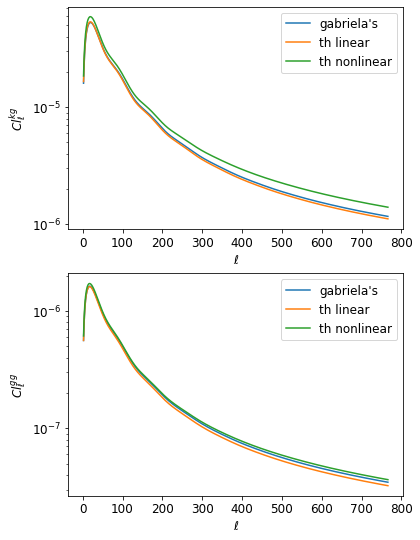

In [12]:
# fig, ax = plt.subplots(2, 1,figsize=(8*1,2*6))
fig, ax = plt.subplots(2, 1,figsize=(6*1,2*4.5))
i,j = 2, 2

clgg_input_g = np.loadtxt(data_path1+'inputgabriela/Clgg_input_z%sf2z%s.dat' %(i,j))
clgg_input = np.loadtxt(data_path1+'input_linear/clgg_input_z%sf2z%s.dat' %(i,j))
clgg_input_nl = np.loadtxt(data_path1+'input_nonlinear/clgg_input_nl_z%sf2z%s.dat' %(i,j))

clkg_input_g = np.loadtxt(data_path1+'inputgabriela/Clkg_input_z%s.dat' %i)
clkg_input = np.loadtxt(data_path1+'input_linear/clkg_input_z%s.dat' %i)
clkg_input_nl = np.loadtxt(data_path1+'input_nonlinear/clkg_input_nl_z%s.dat' %i)

ax[0].plot(ls, clgg_input_g[:,1][ls], label='gabriela\'s')
ax[0].plot(ls, clgg_input[:,1][ls], label='th linear')
ax[0].plot(ls, clgg_input_nl[:,1][ls], label='th nonlinear')
ax[0].legend()
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$Cl^{kg}_{\ell}$')
ax[0].set_yscale('log')

# plot clkg
ax[1].plot(ls, clkg_input_g[:,1][ls], label='gabriela\'s')
ax[1].plot(ls, clkg_input[:,1][ls], label='th linear')
ax[1].plot(ls, clkg_input_nl[:,1][ls], label='th nonlinear')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel(r'$Cl^{gg}_{\ell}$')
ax[1].set_yscale('log')

# Calculating Power Spectrum Gaussian Errors, need checking here

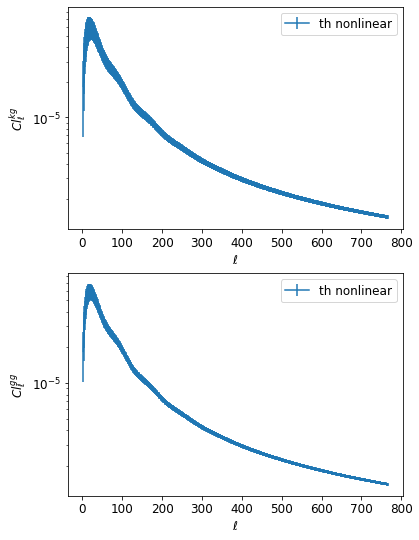

In [13]:
fig, ax = plt.subplots(2, 1,figsize=(6*1,2*4.5))
# gaussian, gg
err = np.sqrt(2/(2*ls+1)*clgg_input_nl[:,1][ls]**2)
ax[0].errorbar(ls, clgg_input_nl[:,1][ls], yerr=err, label='th nonlinear')
ax[0].legend()
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$Cl^{kg}_{\ell}$')
ax[0].set_yscale('log')

# gaussian, kg
nlkk = np.loadtxt(data_path1+'NOISE_ESTIMATE.TXT')
err = np.sqrt(1/(2*ls+1)*(clgg_input_nl[:,1][ls]*(clkk_th[ls]+nlkk[ls])+clgg_input_nl[:,1][ls]**2))
ax[1].errorbar(ls, clgg_input_nl[:,1][ls], yerr=err, label='th nonlinear')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel(r'$Cl^{gg}_{\ell}$')
ax[1].set_yscale('log')

In [14]:
# hp.mollview(mask)
# nide 
nside = 256
cls_arr = []
clkg_arr = []

# Calculate covariance matrix using NaMaster, for i=2, j=2

In [15]:
cl_gg = clgg_input_nl[:,1]
cl_kg = clkg_input_nl[:,1]
cl_kk = clkk_th

In [122]:
# test a mask provided by NaMaster
mask = nmt.mask_apodization(hp.read_map(data_path1 + "mask.fits", verbose=False),
                            1., apotype="Smooth")

In [92]:
# mp_g, mp_k, mp = hp.synfast([cl_gg, cl_kg, cl_kk, np.zeros_like(cl_gg)], nside, verbose=False)
# fg = nmt.NmtField(mask, [mp_g])
# fk = nmt.NmtField(mask, [mp_k])
mp_g = hp.synfast(cl_gg, nside, verbose=False)
fg = nmt.NmtField(mask, [mp_g])

In [128]:
# We will use 20 multipoles per bandpower.
b = nmt.NmtBin.from_nside_linear(nside, 20)

In [95]:
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(fg, fg, b)

cl_coupled = nmt.compute_coupled_cell(fg, fg)
cl_decoupled = w00.decouple_cell(cl_coupled)
n_ell = len(cl_decoupled[0])

In [96]:
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(fg,fg,fg,fg)

In [145]:
# Try to get Cov(Clgg, Clgg
covar_00_00_decoupled = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                                [cl_gg],
                                                [cl_gg],
                                                [cl_gg],
                                                [cl_gg],
                                                w00)
covar_00_00_coupled = nmt.gaussian_covariance(cw, 0, 0, 0, 0,
                                              [cl_gg],
                                              [cl_gg],
                                              [cl_gg],
                                              [cl_gg],
                                              w00, coupled=True)

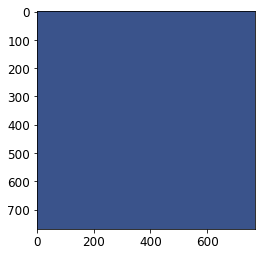

In [146]:
plt.figure()
plt.imshow(covar_00_00_coupled)

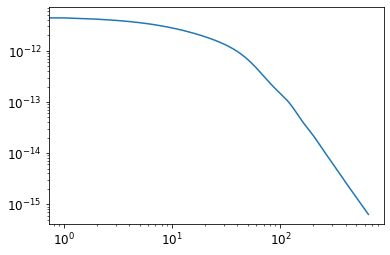

In [162]:
plt.plot(np.diag(covar_00_00_coupled)[50:700])
plt.xscale('log')
plt.yscale('log')